<a href="https://colab.research.google.com/github/MengOonLee/Airflow/blob/main/ECommerce/Model/GenderRace/Sklearn/Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
from csv import DictReader
from codecs import iterdecode
from typing import List, Dict, Iterable
import apache_beam as beam
from apache_beam.pvalue import PBegin
from apache_beam.io.filesystems import FileSystems as beam_fs
from apache_beam.transforms.core import RestrictionProvider
from apache_beam.io.restriction_trackers import OffsetRange, OffsetRestrictionTracker

@beam.ptransform_fn
@beam.typehints.with_input_types(PBegin)
@beam.typehints.with_output_types(Dict[str, str])
def ReadCsvFiles(pbegin: PBegin, file_patterns: List[str]
    ) -> beam.PCollection[Dict[str, str]]:
    
    return (pbegin
        | beam.Create(file_patterns)
        | beam.ParDo(ExpandPattern())
        | beam.ParDo(ReadCsvLines())
        | beam.Reshuffle()
    )

class ExpandPattern(beam.DoFn):
    def process(self, pattern: str) -> Iterable[str]:
        try:
            for match_result in beam_fs.match([pattern])[0].metadata_list:
                yield match_result.path
        except Exception:
            logging.exception(pattern)
            
class CsvLinesTracker(RestrictionProvider):
    def initial_restriction(self, file_name):
        with beam_fs.open(file_name) as file:
            num_row = len(file.readlines())
        return OffsetRange(0, num_row)
    
    def create_tracker(self, restriction):
        return OffsetRestrictionTracker(restriction)
    
    def restriction_size(self, file_name, restriction):
        return restriction.size()
    
class ReadCsvLines(beam.DoFn):
    def process(self, file_name: str, 
        tracker=beam.DoFn.RestrictionParam(CsvLinesTracker())
        ) -> Iterable[Dict[str, str]]:
        try:
            with beam_fs.open(file_name) as file:
                file.seek(tracker.current_restriction().start)
                dict_reader = DictReader(iterdecode(file, 'utf-8'))
                while tracker.try_claim(file.tell()):
                    for row in dict_reader:
                        yield dict(row)
        except Exception:
            logging.exception(file_name)

In [1]:
%%bash
pip install -qU apache-beam[gcp,interactive]==2.38.0
pip check

tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly, which is not installed.
multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you have dill 0.3.1.1.
jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29.
gym 0.17.3 has requirement cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0.
google-colab 1.0.0 has requirement ipykernel~=4.10, but you have ipykernel 5.5.6.
google-colab 1.0.0 has requirement ipython~=5.5.0, but you have ipython 7.33.0.
google-colab 1.0.0 has requirement requests~=2.23.0, but you have requests 2.27.1.
datascience 0.10.6 has requirement folium==0.2.1, but you have folium 0.8.3.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 5.5.6 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBacked.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import pandas as pd
import numpy as np

In [ ]:
import logging
import numpy as np
from typing import Dict, List, Iterable, Any
import apache_beam as beam

@beam.ptransform_fn
@beam.typehints.with_input_types(Dict[str, str])
@beam.typehints.with_output_types(Dict[str, Any])
def CleanLabels(
    pcoll: beam.PCollection[Dict[str, str]],
    label_col: str=None,
    orig_values: List[Any]=None,
    new_values: List[Any]=None
    ) -> beam.PCollection[Dict[str, str]]:
    
    return (pcoll
        | beam.ParDo(StandardizeValue(col=label_col, 
            orig_values=orig_values, new_values=new_values))
        | beam.Reshuffle()
    )

class StandardizeValue(beam.DoFn):
    def __init__(self, col, orig_values, new_values, **kwargs):
        super().__init__(**kwargs)
        self.col = col
        self.orig_values = orig_values
        self.new_values = new_values
        
    def process(self, element: Dict[str, str]
        ) -> Iterable[Dict[str, str]]:
        
        try:
            if self.col is not None:
                for orig, new in zip(self.orig_values, self.new_values):
                    value = np.where(element[self.col]==orig, 
                        new, element[self.col])
                    element[self.col] = value.item()
                yield element
        except Exception:
            logging.exception(element)

In [ ]:
def split_dataset(elem, num_partitions, ratio):
    assert num_partitions == len(ratio)
    bucket = sum(map(ord, str(elem))) % sum(ratio)
    total = 0
    for i, part in enumerate(ratio):
        total += part
        if bucket < total:
            return i
    return len(ratio) - 1

In [ ]:
import logging
logging.getLogger().setLevel(logging.INFO)
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = \
    '/home/meng/work/.GCP_SA/mlee-claritas-bigdata-poc.json'
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions, GoogleCloudOptions, \
    WorkerOptions, StandardOptions

options = PipelineOptions()
options.view_as(GoogleCloudOptions).project = 'claritas-bigdata-poc'
options.view_as(GoogleCloudOptions).region = 'asia-southeast1'
options.view_as(GoogleCloudOptions).temp_location = 'gs://claritas-bigdata-poc/temp'
options.view_as(WorkerOptions).use_public_ips = False
options.view_as(WorkerOptions).subnetwork = 'https://www.googleapis.com/compute/v1/projects/claritas-sharedvpc/regions/asia-southeast1/subnetworks/claritas-cloudai-dev-app-sg'
options.view_as(StandardOptions).runner = 'InteractiveRunner'

class CustomOptions(PipelineOptions):
    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_argument('--input_csv')
        
args = options.view_as(CustomOptions)
args.input_csv = ["./Data/Ogawa_Ecommerce.csv"]

pipeline = beam.Pipeline(options=options)

raw_pc = (pipeline
    | "read csv" >> ReadCsvFiles(args.input_csv)
    | "clean gender" >> CleanLabels(label_col='gender',
        orig_values=['Other'], new_values=['Others'])
    | "clean race" >> CleanLabels(label_col='race',
        orig_values=['Other'], new_values=['Others'])
)

train_pc, test_pc = (raw_pc
    | "partition" >> beam.Partition(split_dataset, 2, [9, 1]))

(train_pc | "count train data" >> beam.combiners.Count.Globally()
    | "print number train data" >> beam.Map(lambda x: print(f"# train data: {x}")))

pipeline.run().wait_until_finish()

INFO:root:Default Python SDK image for environment is apache/beam_python3.8_sdk:2.38.0
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7fc7b41baaf0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7fc7b41bac10> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function pack_combiners at 0x7fc7b41bb160> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7fc7b41bb1f0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7fc7b41bb3a0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7fc7b41bb430> ============

# train data: 20526


In [ ]:
import apache_beam.runners.interactive.interactive_beam as ib

train_df = ib.collect(train_pc)
print("Train data:")
train_df.info()

test_df = ib.collect(test_pc)
print("Test data:")
test_df.info()

Train data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20526 entries, 0 to 20525
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  20526 non-null  object
 1   race           20526 non-null  object
 2   gender         20526 non-null  object
dtypes: object(3)
memory usage: 481.2+ KB


Test data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  2311 non-null   object
 1   race           2311 non-null   object
 2   gender         2311 non-null   object
dtypes: object(3)
memory usage: 54.3+ KB


In [ ]:
def bar_plot(dataframe, col):
    plt_dataframe = dataframe[col].value_counts(normalize=True).mul(100)\
        .rename('%').rename_axis(col).reset_index()
    sns.barplot(data=plt_dataframe, x=col, y='%')
    plt.title(col + " %")
    plt.show()

Train data:


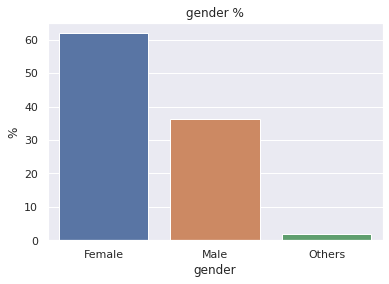

Test data:


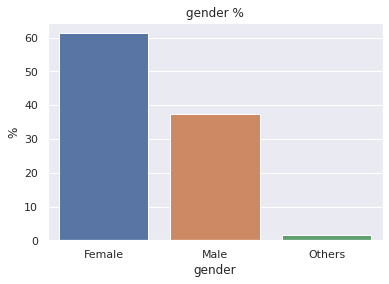

In [ ]:
print("Train data:")
bar_plot(train_df, 'gender')

print("Test data:")
bar_plot(test_df, 'gender')

Train data:


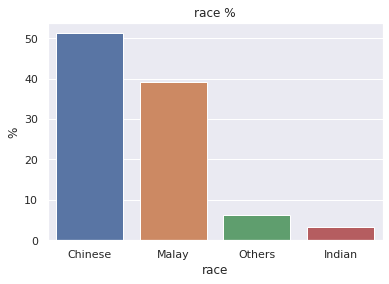

Test data:


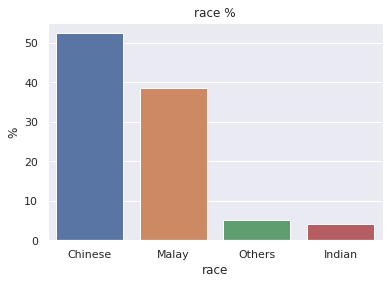

In [ ]:
print("Train data:")
bar_plot(train_df, 'race')

print("Test data:")
bar_plot(test_df, 'race')

In [ ]:
import pandas as pd
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV

def train(dataframe, target_name):
    data, label = dataframe.drop(columns=[target_name]), dataframe[target_name]
    
    preprocessor = ColumnTransformer([
        ('count_vectorizer', CountVectorizer(), 'customer_name')
        ], remainder='drop', n_jobs=-1)
    pipeline = make_pipeline(preprocessor, MultinomialNB())

    param_distributions = {
        'multinomialnb__alpha': uniform()}
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scoring = {'accuracy': make_scorer(accuracy_score),
        'balanced_accuracy': make_scorer(balanced_accuracy_score)}
    model = RandomizedSearchCV(estimator=pipeline, 
        param_distributions=param_distributions, n_iter=100,
        cv=cv, n_jobs=-1, scoring=scoring, refit='accuracy',
        return_train_score=True)
    model.fit(data, label)
    
    cv_results_df = pd.DataFrame(model.cv_results_)
    col_results = [f"param_{name}" for name in param_distributions.keys()]
    col_results += [f"mean_train_{name}" for name in scoring.keys()]
    col_results += [f"std_train_{name}" for name in scoring.keys()]
    col_results += [f"mean_test_{name}" for name in scoring.keys()]
    col_results += [f"std_test_{name}" for name in scoring.keys()]
    cv_results_df = cv_results_df[col_results]\
        .sort_values('mean_test_accuracy', ascending=False)
    cv_results_df.reset_index(inplace=True)

    print("Model best params:", model.best_params_)
    print(f"Train accuracy: {cv_results_df['mean_train_accuracy'][0]:.4f}"
        f"+/- {cv_results_df['std_train_accuracy'][0]:.4f}")
    print(f"Valid accuracy: {cv_results_df['mean_test_accuracy'][0]:.4f}"
        f"+/- {cv_results_df['std_test_accuracy'][0]:.4f}")
    
    train_metrics = cv_results_df[[f"mean_train_{name}" 
        for name in scoring.keys()]]
    sns.boxplot(data=train_metrics, orient='h')
    plt.xlabel('score')
    plt.title('Train scores')
    plt.show()
    
    valid_metrics = cv_results_df[[f"mean_test_{name}" 
        for name in scoring.keys()]]
    sns.boxplot(data=valid_metrics, orient='h')
    plt.xlabel('score')
    plt.title('Valid scores')
    plt.show()
    
    return model, cv_results_df

Model best params: {'multinomialnb__alpha': 0.18300796090738336}
Train accuracy: 0.9073+/- 0.0011
Valid accuracy: 0.7958+/- 0.0089


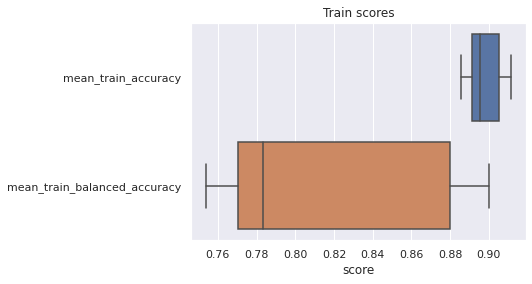

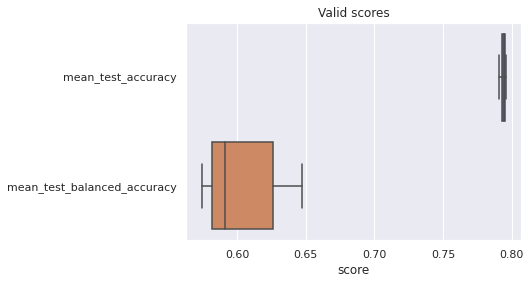

CPU times: user 20.2 s, sys: 1.44 s, total: 21.6 s
Wall time: 53.3 s


In [ ]:
%%time
gender_model, cv_gender_df = train(dataframe=train_df, 
    target_name='gender')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate(model, dataframe, target_name):
    x, y = dataframe.drop(columns=[target_name]), dataframe[target_name]
    print(f"Test accuracy: {model.score(x, y):.4f}")
    y_pred = model.predict(x)
    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm/np.sum(cm, axis=1), 
        index=np.unique(y), columns=np.unique(y))
    
    sns.heatmap(data=cm_df, annot=True, cmap='Reds', fmt='.1%', square=True)
    plt.title("Confusion matrix(%) for test data")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    cls_report = classification_report(y, y_pred, digits=4)
    print(cls_report)

Test accuracy: 0.7893


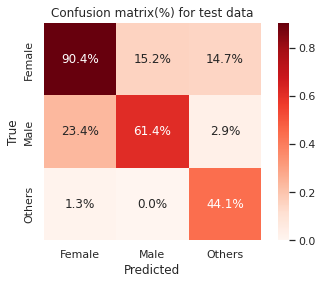

              precision    recall  f1-score   support

      Female     0.7853    0.9040    0.8404      1416
        Male     0.8015    0.6144    0.6956       861
      Others     0.7143    0.4412    0.5455        34

    accuracy                         0.7893      2311
   macro avg     0.7670    0.6532    0.6938      2311
weighted avg     0.7903    0.7893    0.7821      2311



In [ ]:
evaluate(model=gender_model, 
    dataframe=test_df, target_name='gender')

Model best params: {'multinomialnb__alpha': 0.16746839856214968}
Train accuracy: 0.9849+/- 0.0002
Valid accuracy: 0.8998+/- 0.0032


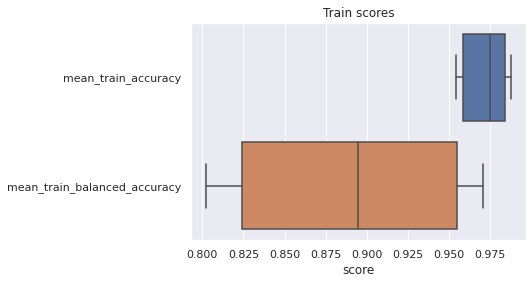

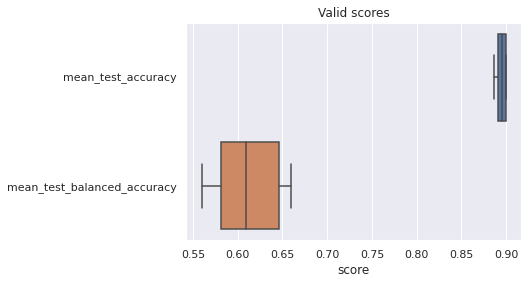

CPU times: user 20.2 s, sys: 722 ms, total: 20.9 s
Wall time: 53 s


In [ ]:
%%time
race_model, cv_race_df = train(dataframe=train_df, 
    target_name='race')

Test accuracy: 0.8987


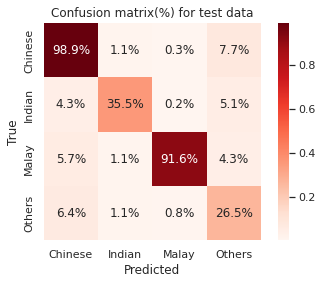

              precision    recall  f1-score   support

     Chinese     0.8577    0.9893    0.9188      1212
      Indian     0.9167    0.3548    0.5116        93
       Malay     0.9855    0.9156    0.9493       889
      Others     0.6078    0.2650    0.3690       117

    accuracy                         0.8987      2311
   macro avg     0.8419    0.6312    0.6872      2311
weighted avg     0.8966    0.8987    0.8863      2311



In [ ]:
evaluate(model=race_model, 
    dataframe=test_df, target_name='race')

In [ ]:
names = ['mei', 'kelvin', 'ahmad', 'siti', 'kumar', 'ogawa sdn. bhd.']
df = pd.DataFrame({'customer_name': names})

gender = gender_model.predict(df)
race = race_model.predict(df)

round_fn = lambda x: np.round(x, 2)
gender_proba = round_fn(np.max(gender_model.predict_proba(df), axis=1))
race_proba = round_fn(np.max(race_model.predict_proba(df), axis=1))

pd.DataFrame({
    'customer_name': names,
    'gender': gender,
    'gender_probability': gender_proba,
    'race': race,
    'race_probability': race_proba})

,customer_name,gender,gender_probability,race,race_probability
0,mei,Female,0.90,Chinese,1.00
1,kelvin,Male,0.92,Chinese,0.93
2,ahmad,Male,0.62,Malay,0.99
3,siti,Female,0.99,Malay,1.00
4,kumar,Male,0.98,Indian,0.96
5,ogawa sdn. bhd.,Others,0.98,Others,0.98
